In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
from itertools import cycle
from fastai.vision import *
from fastai.metrics import *

torch.manual_seed(121)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(121)

In [3]:
train_csv = Path('/home/amey/LTTS/data/train-u1.csv')
valid_csv = Path('/home/amey/LTTS/data/valid.csv')

ALL_LBLS = ['No Finding',
            'Cardiomegaly',
            'Edema',
            'Consolidation',
            'Atelectasis',
            'Pleural Effusion',
            'Enlarged Cardiomediastinum',
            'Lung Opacity',
            'Lung Lesion',
            'Pneumonia',
            'Pneumothorax',
            'Pleural Other',
            'Fracture',
            'Support Devices']

EVAL_LBLS = ['Cardiomegaly',
             'Edema',
             'Consolidation',
             'Atelectasis',
             'Pleural Effusion',]

BS = 32
IMG_SZ = 320
IMG_MEAN = torch.FloatTensor([0.5027, 0.5027, 0.5027])
IMG_STD = torch.FloatTensor([0.2915, 0.2915, 0.2915])
GPU_IDS = [0]
torch.cuda.set_device(0)

EXP = 'temp'
RES_DIR = 'results/'+EXP+'/'
os.makedirs('results/', exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

In [4]:
data_tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1, max_lighting=None,
                          max_warp=0, p_affine=0, p_lighting=0)

train = ImageDataBunch.from_csv('/home1/amey/CheXpert-v1.0-downsampled', csv_labels=train_csv, folder='', 
                               label_col=ALL_LBLS, delimiter=',', suffix='', valid_pct=0, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ).normalize([IMG_MEAN, IMG_STD])

valid = ImageDataBunch.from_csv('/home1/amey/CheXpert-v1.0-downsampled', csv_labels=valid_csv, folder='', seed=0,
                               label_col=ALL_LBLS, delimiter=',', suffix='', valid_pct=1, ds_tfms=data_tfms,
                               bs=BS, size=IMG_SZ).normalize([IMG_MEAN, IMG_STD])

data = DataBunch.create(train_ds=train.train_ds, valid_ds=valid.valid_ds, bs=BS)

/home/amey/.conda/envs/venv/lib/python3.6/site-packages/fastai/data_block.py:454: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [5]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

class AUC():

    def __init__(self, num_cl=14, pick='micro', plot_auc=True, plot_title='ensemble - validation AUC', plot_path='ensemble_valid_ROC_AUC.png'):
        self.id_to_class = {
            0: 'No Finding',
            1: 'Cardiomegaly',
            2: 'Edema',
            3: 'Consolidation',
            4: 'Atelectasis',
            5: 'Pleural Effusion',
            6: 'Enlarged Cardiomediastinum',
            7: 'Lung Opacity',
            8: 'Lung Lesion',
            9: 'Pneumonia',
            10: 'Pneumothorax',
            11: 'Pleural Other',
            12: 'Fracture',
            13: 'Support Devices',
            'micro': 'micro',
            'macro': 'macro',
        }
        self.name = str(self.id_to_class[pick])+'-AUC'
        self.pick = pick
        self.num_cl = num_cl
        self.plot_path = plot_path
        self.plot_title = plot_title
        self.plot_auc = plot_auc
    
    def get_auc(self, targets, outputs, plot_title,plot=True, plot_path=None):
        if plot_path is None:
            plot_path = self.plot_path
        self.outputs = outputs.cpu().detach().numpy()
        self.targets = targets.cpu().numpy()
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(self.num_cl):
          fpr[i], tpr[i], _ = roc_curve(self.targets[:, i], self.outputs[:, i])
          roc_auc[self.id_to_class[i]] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and ROC area
        self.targets, self.outputs = self.targets[:,1:6], self.outputs[:,1:6]
        fpr["micro"], tpr["micro"], _ = roc_curve(self.targets.ravel(), self.outputs.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(1,6)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(1,6):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= 5

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        if plot:
            # Plot all ROC curves
            plt.figure()
            plt.plot(fpr["micro"], tpr["micro"],
                     label='micro (auc- {0:0.4f})'.format(roc_auc["micro"]),
                     color='deeppink', linestyle=':', linewidth=2)

            plt.plot(fpr["macro"], tpr["macro"],
                     label='macro (auc- {0:0.4f})'.format(roc_auc["macro"]),
                     color='navy', linestyle=':', linewidth=2)

            colors = cycle(['blue', 'green', 'red', 'cyan', 'yellow', 'magenta', 'black'])
            for i, color in zip(range(12), colors):
                if roc_auc[self.id_to_class[i]] > 0:
                    plt.plot(fpr[i], tpr[i], color=color, lw=1,
                         label='{0} (auc- {1:0.4f})'.format(self.id_to_class[i], roc_auc[self.id_to_class[i]]))

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('{}'.format(plot_title))
            plt.legend(loc="lower right")
            plt.savefig(plot_path)
            print(plot_path)
            plt.show()
        
        return roc_auc
    
def plain_auc(targets, outputs):

    outputs = outputs.cpu().detach().numpy()
    targets = targets.cpu().numpy()
    roc_auc = {'macro': 0.0}
    for i in range(5):
        print(targets.shape)
        roc_auc[EVAL_LBLS[i]] = roc_auc_score(targets[:, i+1], outputs[:, i+1])
        roc_auc['macro'] += roc_auc[EVAL_LBLS[i]]
    roc_auc['micro'] = roc_auc_score(targets[:,1:6].ravel(), outputs[:,1:6].ravel())
    roc_auc['macro'] = roc_auc['macro']/5.0
    return roc_auc

In [6]:
test_ids = data.valid_ds.items
MyAUC = AUC()
exp_cnt = 0
record_dict, pred_list = [], []
mean_record_dict, mean_pred_list = [], []
min_record_dict, min_pred_list = [], []
max_record_dict, max_pred_list = [], []

In [7]:
def aggr_preds(IDs, X, mode=''):
    df_data = {'Study': list(map(lambda x: 'valid'+'/'.join(x.split('valid')[1].split('/')[:-1]), IDs))}
    for idx in range(len(ALL_LBLS)):
        df_data[ALL_LBLS[idx]] = X[:,idx]
    df = pd.DataFrame(df_data)
    if mode == 'mean':
        df = df.groupby('Study').mean().reset_index()
    elif mode == 'max':
        df = df.groupby('Study').max().reset_index()
    elif mode == 'min':
        df = df.groupby('Study').min().reset_index()
    
    return torch.tensor(np.array(df.iloc[:,1:]))


/home/amey/.conda/envs/venv/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


FinalAUC/fastai-densenet-320-u0-stage-2valid.png


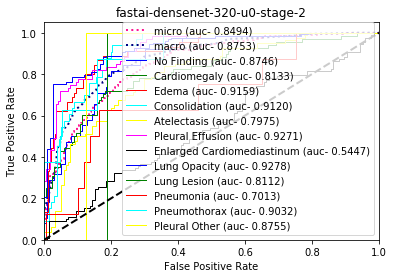

FinalAUC/fastai-densenet-320-u0-stage-2mean_valid.png


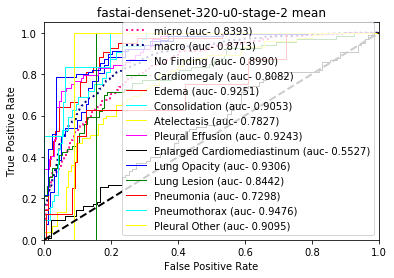

FinalAUC/fastai-densenet-320-u0-stage-2min_valid.png


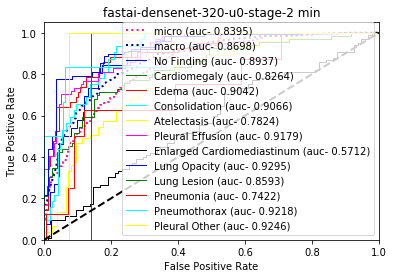

FinalAUC/fastai-densenet-320-u0-stage-2max_valid.png


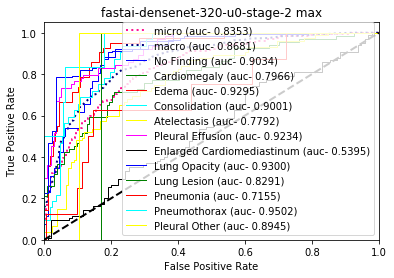

In [8]:
exp_name = 'fastai-densenet-320-u0-stage-2'
learn = cnn_learner(data, models.densenet121)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)


rec = MyAUC.get_auc(y, preds, plot_title=exp_name, plot_path='FinalAUC/'+exp_name+'valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'mean'), aggr_preds(data.valid_ds.x.items, preds, 'mean')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' mean', plot_path='FinalAUC/'+exp_name+'mean_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
mean_record_dict += [rec]
mean_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'min'), aggr_preds(data.valid_ds.x.items, preds, 'min')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' min', plot_path='FinalAUC/'+exp_name+'min_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
min_record_dict += [rec]
min_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'max'), aggr_preds(data.valid_ds.x.items, preds, 'max')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' max', plot_path='FinalAUC/'+exp_name+'max_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
max_record_dict += [rec]
max_pred_list.append(agg_preds)

exp_cnt += 1.0

[tensor([[0.1316, 0.1962, 0.1460,  ..., 0.0047, 0.0511, 0.0184],
         [0.5079, 0.0084, 0.0007,  ..., 0.0047, 0.0171, 0.6232],
         [0.0098, 0.0809, 0.1292,  ..., 0.0888, 0.1100, 0.0667],
         ...,
         [0.0607, 0.2073, 0.5539,  ..., 0.0060, 0.0114, 0.3665],
         [0.3532, 0.2069, 0.0248,  ..., 0.0045, 0.0248, 0.0273],
         [0.0372, 0.1426, 0.0562,  ..., 0.0281, 0.0440, 0.3862]])]

[tensor([[0.1316, 0.1962, 0.1460,  ..., 0.0047, 0.0511, 0.0184],
         [0.5252, 0.0157, 0.0014,  ..., 0.0076, 0.0305, 0.7229],
         [0.0098, 0.0809, 0.1292,  ..., 0.0888, 0.1100, 0.0667],
         ...,
         [0.0607, 0.2073, 0.5539,  ..., 0.0060, 0.0114, 0.3665],
         [0.3532, 0.2069, 0.0248,  ..., 0.0045, 0.0248, 0.0273],
         [0.0372, 0.1426, 0.0562,  ..., 0.0281, 0.0440, 0.3862]])]

FinalAUC/fastai-densenet-320-u1-stage-1valid.png


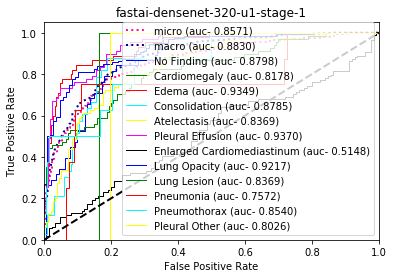

FinalAUC/fastai-densenet-320-u1-stage-1mean_valid.png


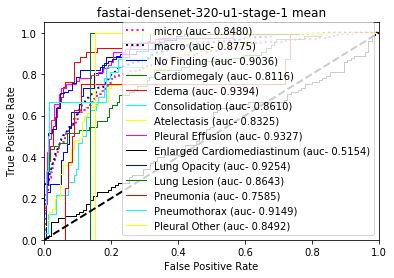

FinalAUC/fastai-densenet-320-u1-stage-1min_valid.png


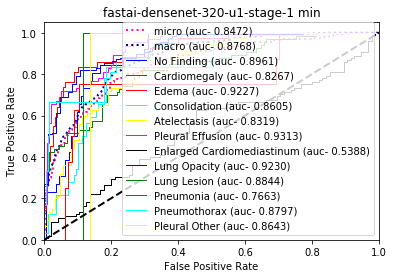

FinalAUC/fastai-densenet-320-u1-stage-1max_valid.png


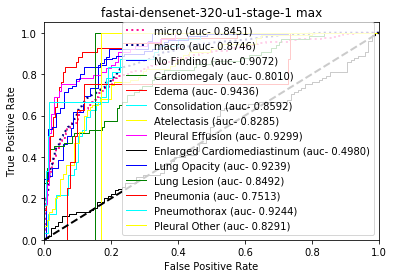

In [11]:
exp_name = 'fastai-densenet-320-u1-stage-1'
learn = cnn_learner(data, models.densenet121)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name, plot_path='FinalAUC/'+exp_name+'valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'mean'), aggr_preds(data.valid_ds.x.items, preds, 'mean')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' mean', plot_path='FinalAUC/'+exp_name+'mean_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
mean_record_dict += [rec]
mean_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'min'), aggr_preds(data.valid_ds.x.items, preds, 'min')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' min', plot_path='FinalAUC/'+exp_name+'min_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
min_record_dict += [rec]
min_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'max'), aggr_preds(data.valid_ds.x.items, preds, 'max')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' max', plot_path='FinalAUC/'+exp_name+'max_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
max_record_dict += [rec]
max_pred_list.append(agg_preds)

exp_cnt += 1.0

FinalAUC/fastai-resnet-320-u0-stage-1valid.png


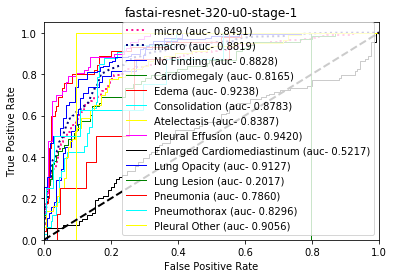

FinalAUC/fastai-resnet-320-u0-stage-1mean_valid.png


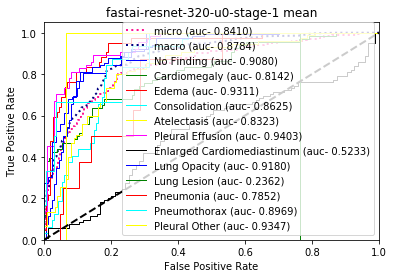

FinalAUC/fastai-resnet-320-u0-stage-1min_valid.png


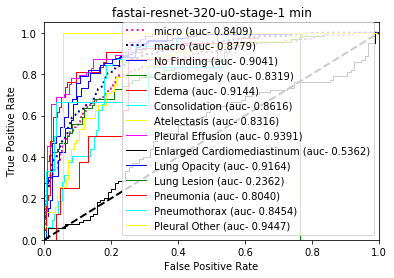

FinalAUC/fastai-resnet-320-u0-stage-1max_valid.png


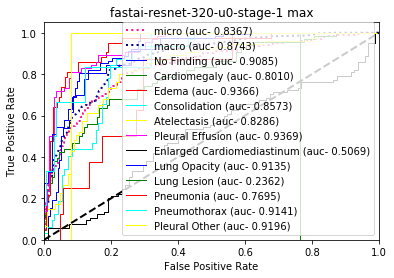

In [12]:
exp_name = 'fastai-resnet-320-u0-stage-1'
learn = cnn_learner(data, models.resnet152)
learn.model = torch.nn.DataParallel(learn.model, device_ids=GPU_IDS)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name, plot_path='FinalAUC/'+exp_name+'valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'mean'), aggr_preds(data.valid_ds.x.items, preds, 'mean')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' mean', plot_path='FinalAUC/'+exp_name+'mean_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
mean_record_dict += [rec]
mean_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'min'), aggr_preds(data.valid_ds.x.items, preds, 'min')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' min', plot_path='FinalAUC/'+exp_name+'min_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
min_record_dict += [rec]
min_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'max'), aggr_preds(data.valid_ds.x.items, preds, 'max')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' max', plot_path='FinalAUC/'+exp_name+'max_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
max_record_dict += [rec]
max_pred_list.append(agg_preds)

exp_cnt += 1.0

FinalAUC/fastai-resnet-320-u1-stage-2valid.png


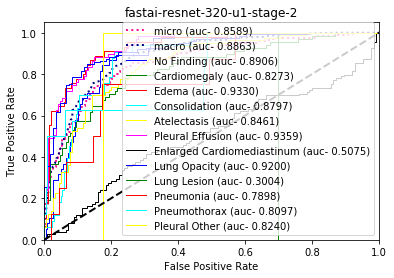

FinalAUC/fastai-resnet-320-u1-stage-2mean_valid.png


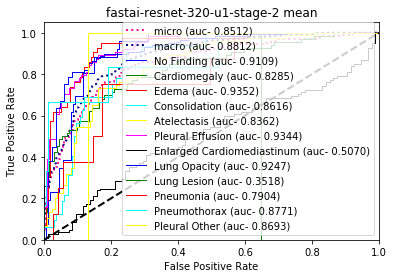

FinalAUC/fastai-resnet-320-u1-stage-2min_valid.png


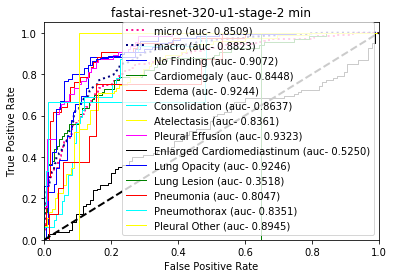

FinalAUC/fastai-resnet-320-u1-stage-2max_valid.png


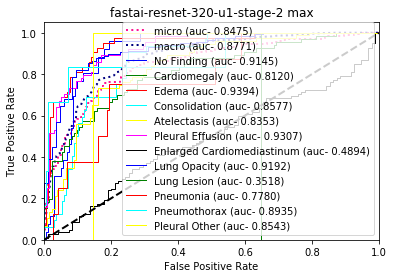

In [13]:
exp_name = 'fastai-resnet-320-u1-stage-2'
learn = cnn_learner(data, models.resnet152)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name, plot_path='FinalAUC/'+exp_name+'valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'mean'), aggr_preds(data.valid_ds.x.items, preds, 'mean')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' mean', plot_path='FinalAUC/'+exp_name+'mean_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
mean_record_dict += [rec]
mean_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'min'), aggr_preds(data.valid_ds.x.items, preds, 'min')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' min', plot_path='FinalAUC/'+exp_name+'min_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
min_record_dict += [rec]
min_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'max'), aggr_preds(data.valid_ds.x.items, preds, 'max')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' max', plot_path='FinalAUC/'+exp_name+'max_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
max_record_dict += [rec]
max_pred_list.append(agg_preds)

exp_cnt += 1.0

FinalAUC/fastai-resnext-320-u1-stage-1valid.png


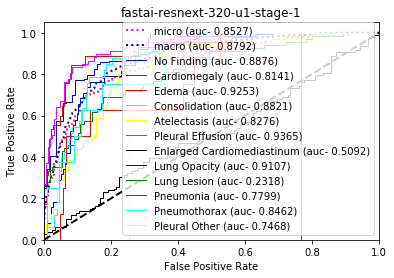

FinalAUC/fastai-resnext-320-u1-stage-1mean_valid.png


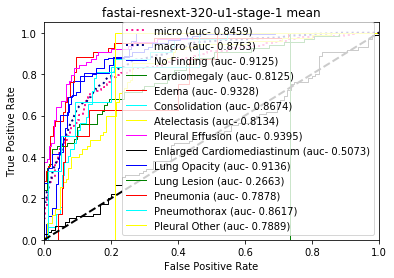

FinalAUC/fastai-resnext-320-u1-stage-1min_valid.png


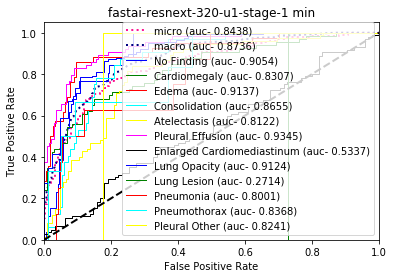

FinalAUC/fastai-resnext-320-u1-stage-1max_valid.png


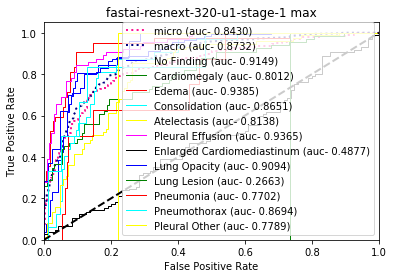

In [14]:
exp_name = 'fastai-resnext-320-u1-stage-1'

from resnext import resnext101_64x4d
model = resnext101_64x4d()
model.last_linear = nn.Sequential(nn.Linear(32768, 2048), 
                                  nn.ReLU(True),
                                  nn.Dropout(),
                                  nn.Linear(2048, 14))
learn = Learner(data, model)
learn.model = torch.nn.DataParallel(learn.model, device_ids=GPU_IDS)
learn.load(exp_name)

preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name, plot_path='FinalAUC/'+exp_name+'valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'mean'), aggr_preds(data.valid_ds.x.items, preds, 'mean')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' mean', plot_path='FinalAUC/'+exp_name+'mean_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
mean_record_dict += [rec]
mean_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'min'), aggr_preds(data.valid_ds.x.items, preds, 'min')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' min', plot_path='FinalAUC/'+exp_name+'min_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
min_record_dict += [rec]
min_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'max'), aggr_preds(data.valid_ds.x.items, preds, 'max')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' max', plot_path='FinalAUC/'+exp_name+'max_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
max_record_dict += [rec]
max_pred_list.append(agg_preds)

exp_cnt += 1.0

FinalAUC/fastai-vgg-320-u0-stage-2valid.png


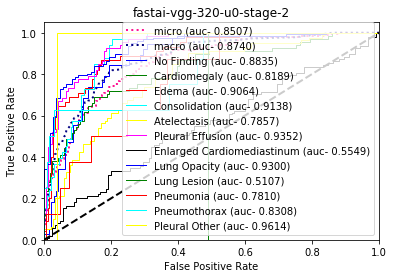

FinalAUC/fastai-vgg-320-u0-stage-2mean_valid.png


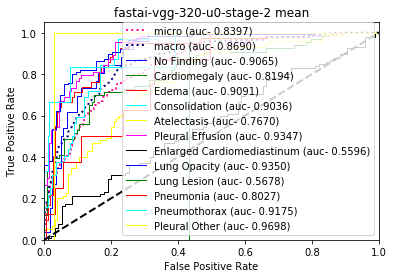

FinalAUC/fastai-vgg-320-u0-stage-2min_valid.png


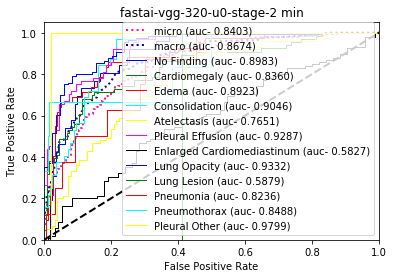

FinalAUC/fastai-vgg-320-u0-stage-2max_valid.png


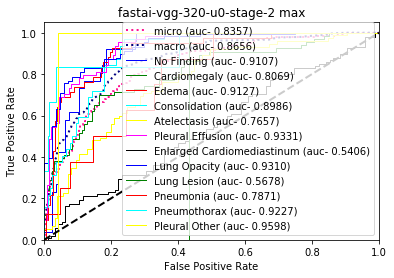

In [15]:
exp_name = 'fastai-vgg-320-u0-stage-2'
learn = cnn_learner(data, models.vgg19_bn)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name, plot_path='FinalAUC/'+exp_name+'valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'mean'), aggr_preds(data.valid_ds.x.items, preds, 'mean')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' mean', plot_path='FinalAUC/'+exp_name+'mean_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
mean_record_dict += [rec]
mean_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'min'), aggr_preds(data.valid_ds.x.items, preds, 'min')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' min', plot_path='FinalAUC/'+exp_name+'min_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
min_record_dict += [rec]
min_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'max'), aggr_preds(data.valid_ds.x.items, preds, 'max')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' max', plot_path='FinalAUC/'+exp_name+'max_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
max_record_dict += [rec]
max_pred_list.append(agg_preds)

exp_cnt += 1.0

FinalAUC/fastai-vgg-320-u1-stage-1valid.png


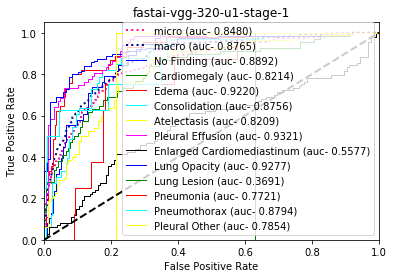

FinalAUC/fastai-vgg-320-u1-stage-1mean_valid.png


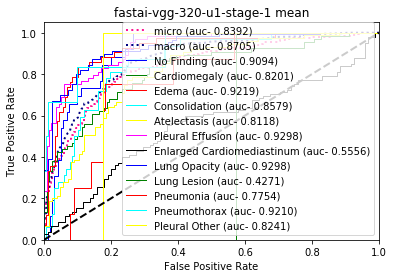

FinalAUC/fastai-vgg-320-u1-stage-1min_valid.png


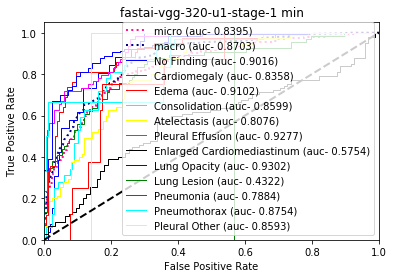

FinalAUC/fastai-vgg-320-u1-stage-1max_valid.png


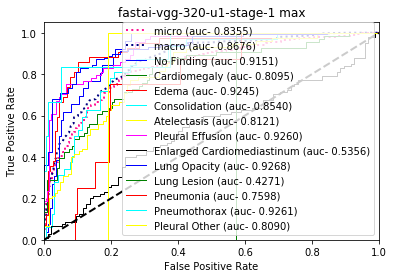

In [16]:
exp_name = 'fastai-vgg-320-u1-stage-1'
learn = cnn_learner(data, models.vgg19_bn)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name, plot_path='FinalAUC/'+exp_name+'valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'mean'), aggr_preds(data.valid_ds.x.items, preds, 'mean')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' mean', plot_path='FinalAUC/'+exp_name+'mean_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
mean_record_dict += [rec]
mean_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'min'), aggr_preds(data.valid_ds.x.items, preds, 'min')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' min', plot_path='FinalAUC/'+exp_name+'min_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
min_record_dict += [rec]
min_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'max'), aggr_preds(data.valid_ds.x.items, preds, 'max')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' max', plot_path='FinalAUC/'+exp_name+'max_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
max_record_dict += [rec]
max_pred_list.append(agg_preds)

exp_cnt += 1.0

FinalAUC/fastai-densenet-CT-phase2-u1-stage-2valid.png


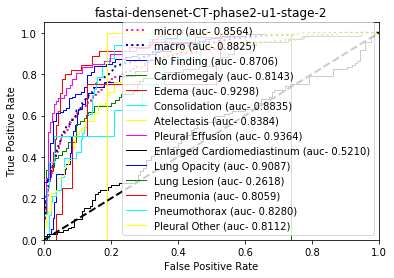

FinalAUC/fastai-densenet-CT-phase2-u1-stage-2mean_valid.png


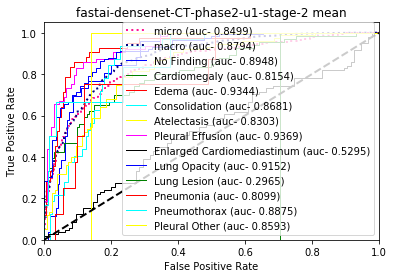

FinalAUC/fastai-densenet-CT-phase2-u1-stage-2min_valid.png


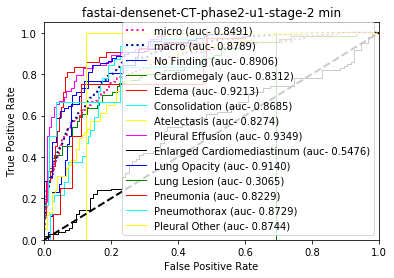

FinalAUC/fastai-densenet-CT-phase2-u1-stage-2max_valid.png


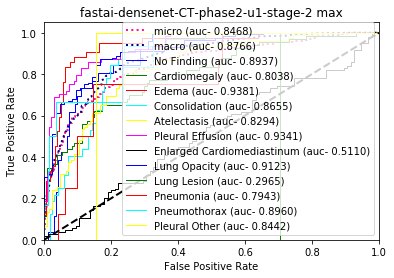

In [17]:
exp_name = 'fastai-densenet-CT-phase2-u1-stage-2'
learn = cnn_learner(data, models.densenet121)
learn.load(exp_name)
preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

rec = MyAUC.get_auc(y, preds, plot_title=exp_name, plot_path='FinalAUC/'+exp_name+'valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]
pred_list.append(preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'mean'), aggr_preds(data.valid_ds.x.items, preds, 'mean')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' mean', plot_path='FinalAUC/'+exp_name+'mean_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
mean_record_dict += [rec]
mean_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'min'), aggr_preds(data.valid_ds.x.items, preds, 'min')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' min', plot_path='FinalAUC/'+exp_name+'min_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
min_record_dict += [rec]
min_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'max'), aggr_preds(data.valid_ds.x.items, preds, 'max')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' max', plot_path='FinalAUC/'+exp_name+'max_valid.png')
rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
max_record_dict += [rec]
max_pred_list.append(agg_preds)

exp_cnt += 1.0

In [18]:
# exp_name = 'fastai-densenet-320-u1-lsr-stage-2'
# learn = cnn_learner(data, models.densenet121)
# learn.load(exp_name)
# preds, y, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

# rec = MyAUC.get_auc(y, preds, plot_title=exp_name, plot_path='FinalAUC/'+exp_name+'valid.png')
# rec = [exp_name] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
# record_dict += [rec]
# pred_list.append(preds)

# test_preds += preds
# exp_cnt += 1.0

/home/amey/.conda/envs/venv/lib/python3.6/site-packages/scipy/optimize/_minimize.py:516: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


 final_simplex: (array([[ 1.794421,  1.861856, -1.361575,  1.687686,  2.100803,  0.796445, -0.939036,  1.698051],
       [ 1.794437,  1.861849, -1.361594,  1.687667,  2.10081 ,  0.796436, -0.939016,  1.698044],
       [ 1.794431,  1.861841, -1.36162 ,  1.687653,  2.100819,  0.796419, -0.938984,  1.698066],
       [ 1.79443 ,  1.861851, -1.36158 ,  1.687672,  2.100804,  0.796449, -0.939024,  1.698028],
       ...,
       [ 1.794431,  1.861845, -1.361595,  1.68766 ,  2.100818,  0.796436, -0.939   ,  1.698034],
       [ 1.794426,  1.861857, -1.361583,  1.687664,  2.100803,  0.796442, -0.939031,  1.698046],
       [ 1.794428,  1.861837, -1.361572,  1.687661,  2.100798,  0.796441, -0.938999,  1.698035],
       [ 1.794431,  1.861849, -1.36159 ,  1.687674,  2.100809,  0.796443, -0.939022,  1.69804 ]]), array([-0.863092, -0.863092, -0.863092, -0.863092, -0.863092, -0.863092, -0.863092, -0.863092, -0.863092]))
           fun: -0.8630920645545432
       message: 'Optimization terminated successf

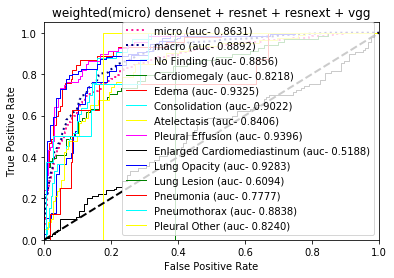

FinalAUC/mean_micro_ensemble_valid.png


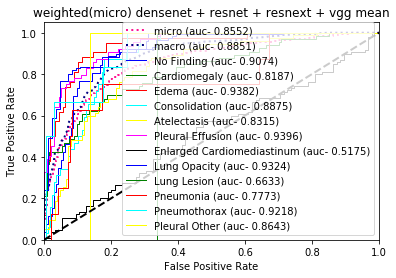

FinalAUC/min_micro_ensemble_valid.png


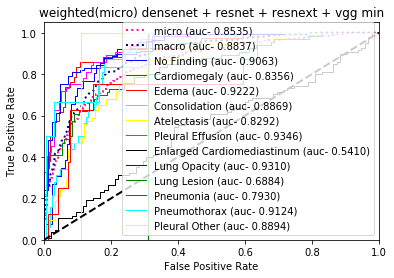

FinalAUC/max_micro_ensemble_valid.png


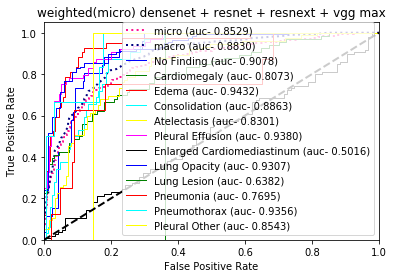

In [19]:
import scipy

wts = np.array([1]*len(pred_list))

def auc_val(w, get_wtd=False):
    wtd_pred = pred_list[0]*0
    for idx in range(len(pred_list)):
        wtd_pred += w[idx]*pred_list[idx]
    if get_wtd:
        return wtd_pred
    return -MyAUC.get_auc(y, wtd_pred, plot_title='temp', plot=False)['micro']
    
exp_name = 'weighted(micro) densenet + resnet + resnext + vgg'

opt = scipy.optimize.minimize(auc_val, [1]*len(pred_list), bounds=(0,1), method="Nelder-Mead")

print(opt)
preds = auc_val(opt.x, get_wtd=True)/exp_cnt

rec = MyAUC.get_auc(y, preds, plot_title='weighted(micro) densenet + resnet + resnext + vgg', plot_path='FinalAUC/micro_ensemble_valid.png')
rec = ['weighted(micro) ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'mean'), aggr_preds(data.valid_ds.x.items, preds, 'mean')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' mean', plot_path='FinalAUC/mean_micro_ensemble_valid.png')
rec = ['weighted(micro) ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
mean_record_dict += [rec]
mean_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'min'), aggr_preds(data.valid_ds.x.items, preds, 'min')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' min', plot_path='FinalAUC/min_micro_ensemble_valid.png')
rec = ['weighted(micro) ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
min_record_dict += [rec]
min_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'max'), aggr_preds(data.valid_ds.x.items, preds, 'max')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' max', plot_path='FinalAUC/max_micro_ensemble_valid.png')
rec = ['weighted(micro) ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
max_record_dict += [rec]
max_pred_list.append(agg_preds)

exp_cnt += 1.0

 final_simplex: (array([[1.079583, 1.001016, 1.039606, 1.043426, 0.949456, 1.024005, 0.856526, 1.035081],
       [1.079587, 1.001022, 1.039608, 1.04342 , 0.949447, 1.024003, 0.856538, 1.035078],
       [1.079578, 1.001031, 1.039607, 1.043421, 0.949458, 1.02401 , 0.856533, 1.035054],
       [1.079566, 1.001017, 1.039612, 1.043435, 0.949452, 1.024006, 0.856528, 1.035062],
       ...,
       [1.07957 , 1.001021, 1.039603, 1.043431, 0.949449, 1.024014, 0.856532, 1.035071],
       [1.079568, 1.001027, 1.039604, 1.043433, 0.949456, 1.023998, 0.856542, 1.035066],
       [1.079598, 1.000968, 1.039578, 1.043395, 0.949487, 1.023975, 0.856587, 1.035093],
       [1.079574, 1.001014, 1.0396  , 1.043394, 0.949479, 1.023994, 0.85657 , 1.035063]]), array([-0.890571, -0.890571, -0.890571, -0.890571, -0.890571, -0.890571, -0.890571, -0.890571, -0.890571]))
           fun: -0.89057109957717
       message: 'Optimization terminated successfully.'
          nfev: 178
           nit: 66
        status: 0
  

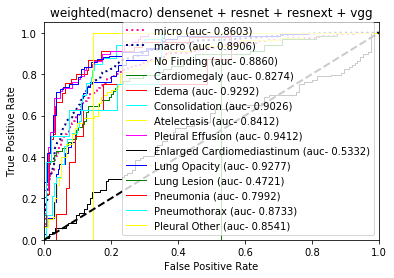

FinalAUC/mean_macro_ensemble_valid.png


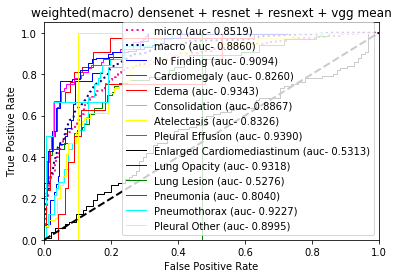

FinalAUC/min_macro_ensemble_valid.png


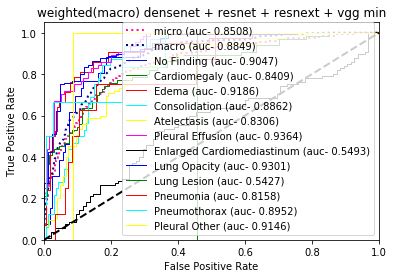

FinalAUC/max_macro_ensemble_valid.png


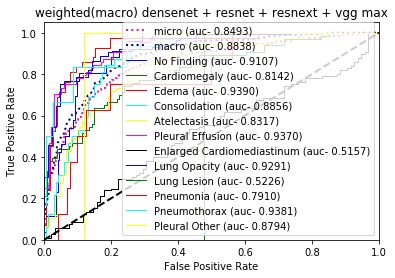

In [20]:
import scipy

wts = np.array([1]*len(pred_list))

def auc_val(w, get_wtd=False):
    wtd_pred = pred_list[0]*0
    for idx in range(len(pred_list)):
        wtd_pred += w[idx]*pred_list[idx]
    if get_wtd:
        return wtd_pred
    return -MyAUC.get_auc(y, wtd_pred, plot_title='temp', plot=False)['macro']

exp_name = 'weighted(macro) densenet + resnet + resnext + vgg'

opt = scipy.optimize.minimize(auc_val, [1]*len(pred_list), bounds=(0,1), method="Nelder-Mead")

print(opt)
preds = auc_val(opt.x, get_wtd=True)/exp_cnt

rec = MyAUC.get_auc(y, preds, plot_title='weighted(macro) densenet + resnet + resnext + vgg', plot_path='FinalAUC/macro_ensemble_valid.png')
rec = ['weighted(macro) ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'mean'), aggr_preds(data.valid_ds.x.items, preds, 'mean')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' mean', plot_path='FinalAUC/mean_macro_ensemble_valid.png')
rec = ['weighted(macro) ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
mean_record_dict += [rec]
mean_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'min'), aggr_preds(data.valid_ds.x.items, preds, 'min')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' min', plot_path='FinalAUC/min_macro_ensemble_valid.png')
rec = ['weighted(micro) ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
min_record_dict += [rec]
min_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'max'), aggr_preds(data.valid_ds.x.items, preds, 'max')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' max', plot_path='FinalAUC/max_macro_ensemble_valid.png')
rec = ['weighted(micro) ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
max_record_dict += [rec]
max_pred_list.append(agg_preds)

exp_cnt += 1.0

FinalAUC/equal_ensemble_valid.png


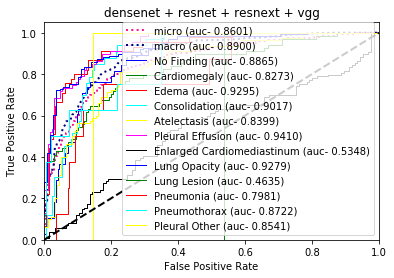

FinalAUC/mean_ensemble_valid.png


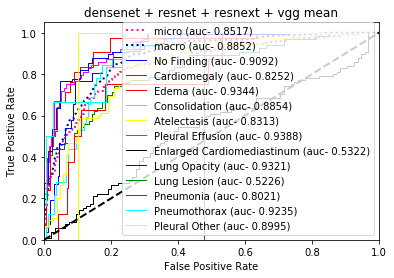

FinalAUC/min_ensemble_valid.png


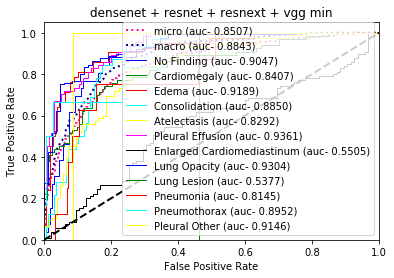

FinalAUC/max_ensemble_valid.png


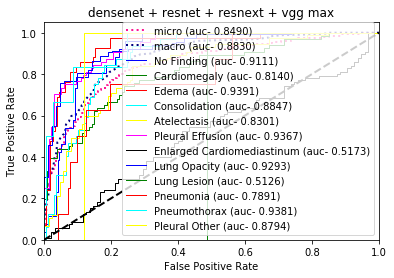

In [21]:
preds = auc_val([1]*int(exp_cnt), get_wtd=True)

exp_name = 'densenet + resnet + resnext + vgg'
rec = MyAUC.get_auc(y, preds, plot_title='densenet + resnet + resnext + vgg', plot_path='FinalAUC/equal_ensemble_valid.png')
rec = ['ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
record_dict += [rec]


agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'mean'), aggr_preds(data.valid_ds.x.items, preds, 'mean')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' mean', plot_path='FinalAUC/mean_ensemble_valid.png')
rec = ['ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
mean_record_dict += [rec]
mean_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'min'), aggr_preds(data.valid_ds.x.items, preds, 'min')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' min', plot_path='FinalAUC/min_ensemble_valid.png')
rec = ['ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
min_record_dict += [rec]
min_pred_list.append(agg_preds)

agg_y, agg_preds = aggr_preds(data.valid_ds.x.items, y, 'max'), aggr_preds(data.valid_ds.x.items, preds, 'max')
rec = MyAUC.get_auc(agg_y, agg_preds, plot_title=exp_name+' max', plot_path='FinalAUC/max_ensemble_valid.png')
rec = ['ensemble'] + [rec[dis] for dis in EVAL_LBLS]+[rec['micro'], rec['macro']]
max_record_dict += [rec]
max_pred_list.append(agg_preds)

exp_cnt += 1.0

In [22]:
import pandas as pd

records = np.array(record_dict)
df_data = {'exp': records[:,0]}
records = np.around(np.array(records[:,1:], dtype=float), decimals=4)
df_data['micro'] = records[:,-2]
df_data['macro'] = records[:,-1]

for idx, dis in enumerate(EVAL_LBLS):
    df_data[dis] = records[:,idx]
    
record_df = pd.DataFrame(df_data)
record_df.to_csv('records.csv', index=False)
record_df

records = np.array(mean_record_dict)
df_data = {'exp': records[:,0]}
records = np.around(np.array(records[:,1:], dtype=float), decimals=4)
df_data['micro'] = records[:,-2]
df_data['macro'] = records[:,-1]

for idx, dis in enumerate(EVAL_LBLS):
    df_data[dis] = records[:,idx]
    
record_df = pd.DataFrame(df_data)
record_df.to_csv('mean_records.csv', index=False)
record_df

records = np.array(min_record_dict)
df_data = {'exp': records[:,0]}
records = np.around(np.array(records[:,1:], dtype=float), decimals=4)
df_data['micro'] = records[:,-2]
df_data['macro'] = records[:,-1]

for idx, dis in enumerate(EVAL_LBLS):
    df_data[dis] = records[:,idx]
    
record_df = pd.DataFrame(df_data)
record_df.to_csv('min_records.csv', index=False)
record_df

records = np.array(max_record_dict)
df_data = {'exp': records[:,0]}
records = np.around(np.array(records[:,1:], dtype=float), decimals=4)
df_data['micro'] = records[:,-2]
df_data['macro'] = records[:,-1]

for idx, dis in enumerate(EVAL_LBLS):
    df_data[dis] = records[:,idx]
    
record_df = pd.DataFrame(df_data)
record_df.to_csv('max_records.csv', index=False)
record_df

,exp,micro,macro,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
0,fastai-densenet-320-u0-stage-2,0.8353,0.8681,0.7966,0.9295,0.9001,0.7792,0.9234
1,fastai-densenet-320-u1-stage-1,0.8451,0.8746,0.8010,0.9436,0.8592,0.8285,0.9299
2,fastai-resnet-320-u0-stage-1,0.8367,0.8743,0.8010,0.9366,0.8573,0.8286,0.9369
3,fastai-resnet-320-u1-stage-2,0.8475,0.8771,0.8120,0.9394,0.8577,0.8353,0.9307
4,fastai-resnext-320-u1-stage-1,0.8430,0.8732,0.8012,0.9385,0.8651,0.8138,0.9365
5,fastai-vgg-320-u0-stage-2,0.8357,0.8656,0.8069,0.9127,0.8986,0.7657,0.9331
6,fastai-vgg-320-u1-stage-1,0.8355,0.8676,0.8095,0.9245,0.8540,0.8121,0.9260
7,fastai-densenet-CT-phase2-u1-stage-2,0.8468,0.8766,0.8038,0.9381,0.8655,0.8294,0.9341
8,weighted(micro) ensemble,0.8529,0.8830,0.8073,0.9432,0.8863,0.8301,0.9380
9,weighted(micro) ensemble,0.8493,0.8838,0.8142,0.9390,0.8856,0.8317,0.9370


In [3]:
import pandas as pd
df = pd.read_csv('mean_records.csv')
df

,exp,micro,macro,Cardiomegaly,Edema,Consolidation,Atelectasis,Pleural Effusion
0,fastai-densenet-320-u0-stage-2,0.8393,0.8713,0.8082,0.9251,0.9053,0.7827,0.9243
1,fastai-densenet-320-u1-stage-1,0.8480,0.8775,0.8116,0.9394,0.8610,0.8325,0.9327
2,fastai-resnet-320-u0-stage-1,0.8410,0.8784,0.8142,0.9311,0.8625,0.8323,0.9403
3,fastai-resnet-320-u1-stage-2,0.8512,0.8812,0.8285,0.9352,0.8616,0.8362,0.9344
4,fastai-resnext-320-u1-stage-1,0.8459,0.8753,0.8125,0.9328,0.8674,0.8134,0.9395
5,fastai-vgg-320-u0-stage-2,0.8397,0.8690,0.8194,0.9091,0.9036,0.7670,0.9347
6,fastai-vgg-320-u1-stage-1,0.8392,0.8705,0.8201,0.9219,0.8579,0.8118,0.9298
7,fastai-densenet-CT-phase2-u1-stage-2,0.8499,0.8794,0.8154,0.9344,0.8681,0.8303,0.9369
8,weighted(micro) ensemble,0.8552,0.8851,0.8187,0.9382,0.8875,0.8315,0.9396
9,weighted(macro) ensemble,0.8519,0.8860,0.8260,0.9343,0.8867,0.8326,0.9390
